In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/pabloohop/Desktop/heart_failure_clinical_records_dataset.csv')

In [12]:
#Print out data from csv
print(data.head())
print(data.describe())
print(data.info())
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data.drop(['DEATH_EVENT'], axis=1))
data_scaled = pd.DataFrame(features_scaled, columns=data.columns[:-1])
data_scaled['DEATH_EVENT'] = data['DEATH_EVENT']


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

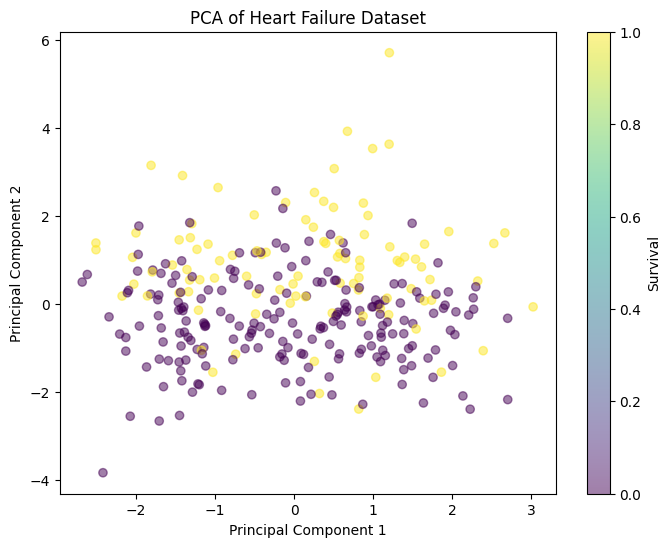

In [13]:
#PCA, to reduce dimensionality
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_scaled.drop(['DEATH_EVENT'], axis=1))
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data['DEATH_EVENT'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Heart Failure Dataset')
plt.colorbar(label='Survival')
plt.show()


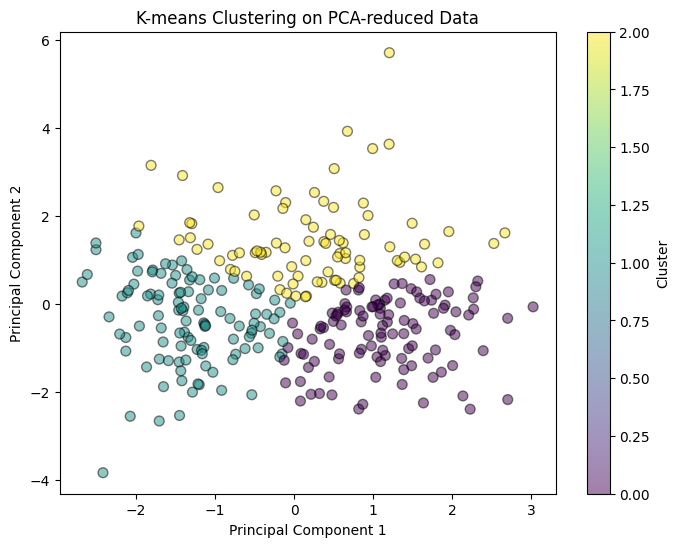

In [14]:
# K-means clustering with 3 clusters to the transformed data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.5)
plt.title('K-means Clustering on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


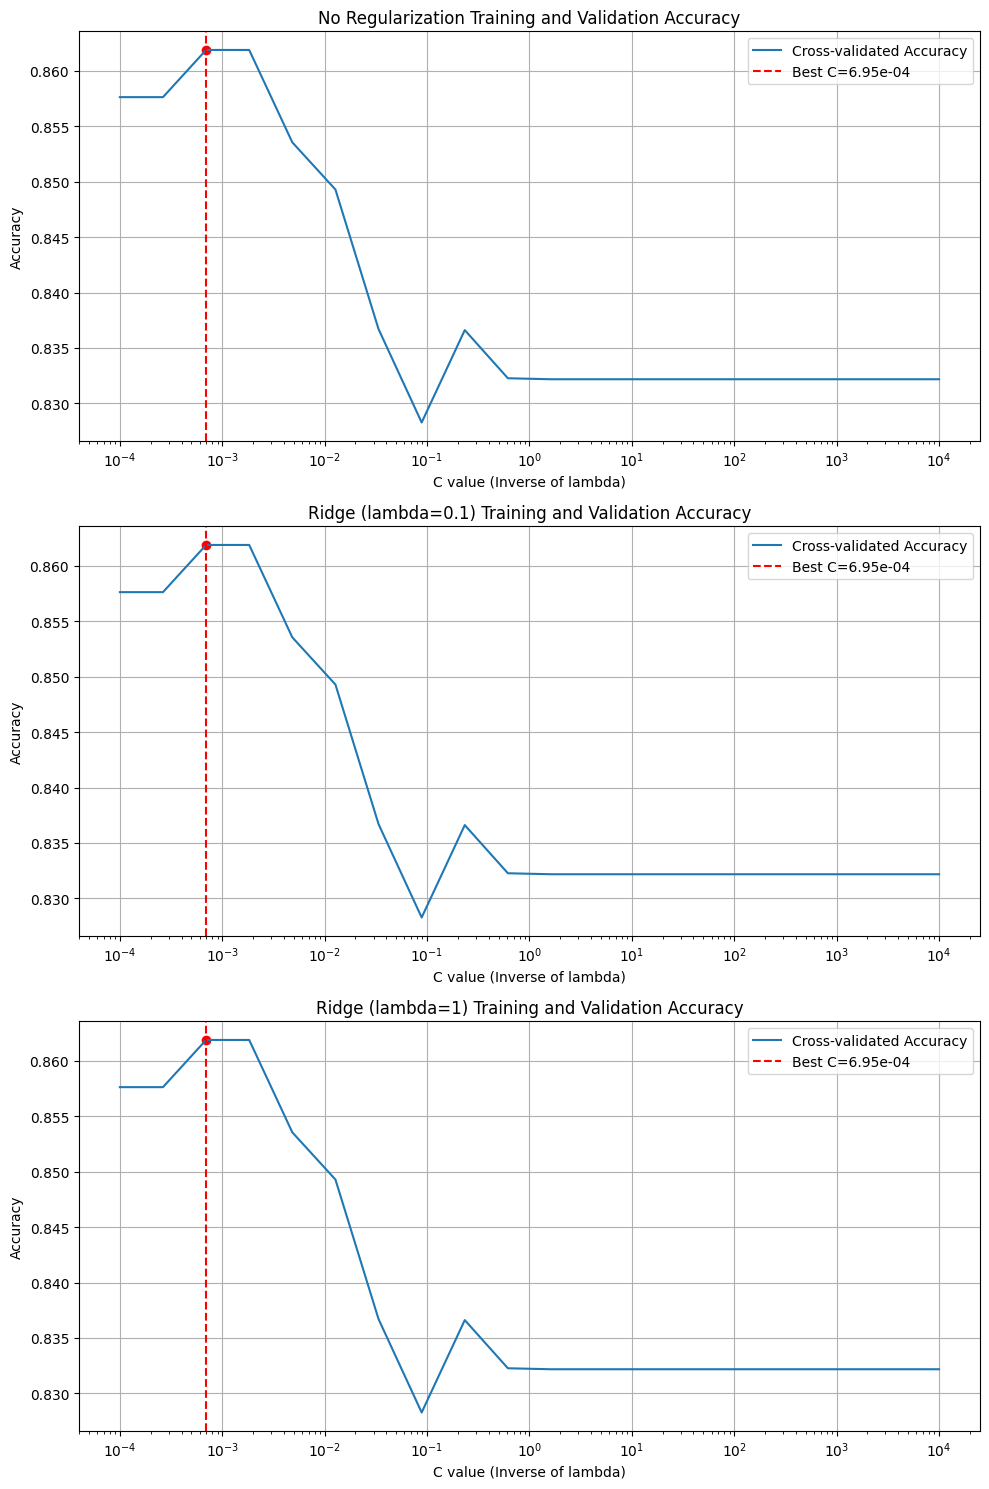

Model: No Regularization
  Training Accuracy: 0.8745
  Validation Accuracy: 0.8000
  Precision: 0.9333
  Recall: 0.5600
  F1 Score: 0.7000
  Confusion Matrix:
[[34  1]
 [11 14]]

Model: Ridge (lambda=0.1)
  Training Accuracy: 0.8745
  Validation Accuracy: 0.8000
  Precision: 0.9333
  Recall: 0.5600
  F1 Score: 0.7000
  Confusion Matrix:
[[34  1]
 [11 14]]

Model: Ridge (lambda=1)
  Training Accuracy: 0.8745
  Validation Accuracy: 0.8167
  Precision: 0.9375
  Recall: 0.6000
  F1 Score: 0.7317
  Confusion Matrix:
[[34  1]
 [10 15]]



In [19]:
#Logistic Regression Code
X = data_scaled.drop(['DEATH_EVENT'], axis=1)
y = data_scaled['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
log_reg_no_reg = LogisticRegression(penalty='l2', C=1e9, solver='liblinear', random_state=42)  # No regularization
log_reg_ridge_01 = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=42)  # Ridge lambda = 0.1
log_reg_ridge_1 = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)    # Ridge lambda = 1

models = {'No Regularization': log_reg_no_reg, 'Ridge (lambda=0.1)': log_reg_ridge_01, 'Ridge (lambda=1)': log_reg_ridge_1}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train) 
    results[name] = {
        'training_accuracy': accuracy_score(y_train, y_train_pred),
        'validation_accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

log_reg_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 20), cv=5, penalty='l2', solver='liblinear', random_state=42)
log_reg_cv.fit(X_train, y_train)

mean_accuracy = np.mean(log_reg_cv.scores_[1], axis=0)
C_values = log_reg_cv.Cs_
best_C_index = np.where(log_reg_cv.Cs_ == log_reg_cv.C_[0])[0][0]
best_accuracy = mean_accuracy[best_C_index]

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (name, metrics) in enumerate(results.items()):
    axs[i].plot(C_values, mean_accuracy, label='Cross-validated Accuracy')
    axs[i].axvline(x=C_values[best_C_index], color='red', linestyle='--', label=f'Best C={log_reg_cv.C_[0]:.2e}')
    axs[i].scatter(C_values[best_C_index], best_accuracy, color='red')
    axs[i].set_xscale('log')
    axs[i].set_title(f'{name} Training and Validation Accuracy')
    axs[i].set_xlabel('C value (Inverse of lambda)')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"  Training Accuracy: {metrics['training_accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['validation_accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    print(f"  Confusion Matrix:\n{metrics['confusion_matrix']}\n")